In [240]:
import time
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import tools
from imp import reload
reload(tools)
from tools import syn_registration
%matplotlib inline

import dipy.tracking.streamline as dts
import dipy.tracking.utils as dtu
import dipy.data as dpd

In [2]:
import nibabel as nib
import dipy.data as dpd

In [3]:
ni, gtab = dpd.read_stanford_hardi()

In [4]:
hardi_data = ni.get_data()
hardi_affine = ni.get_affine()

In [5]:
b0 = hardi_data[..., gtab.b0s_mask]

In [6]:
mean_b0 = np.mean(b0, -1)

In [7]:
ni_b0 = nib.Nifti1Image(mean_b0, hardi_affine)

In [8]:
ni_b0.to_filename('mean_b0.nii')

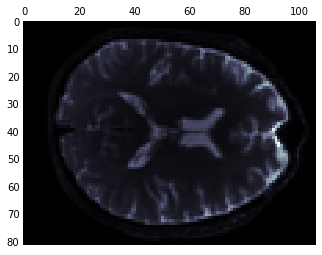

In [9]:
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)

In [10]:
MNI_T2 = nib.load('/Users/arokem/source/AFQ/templates/mni_icbm152_nlin_asym_09a_nifti/mni_icbm152_t2_tal_nlin_asym_09a.nii')

In [11]:
MNI_T2_data = MNI_T2.get_data()

In [12]:
MNI_T2_affine = MNI_T2.get_affine()

In [13]:
warped_b0, mapping = syn_registration(mean_b0, MNI_T2_data, moving_grid2world=hardi_affine, static_grid2world=MNI_T2_affine, 
                                      metric='CC', dim=3, level_iters = [10, 10, 5], prealign=None)

Creating scale space from the moving image. Levels: 3. Sigma factor: 0.200000.
Creating scale space from the static image. Levels: 3. Sigma factor: 0.200000.
Optimizing level 2
Optimizing level 1
Optimizing level 0


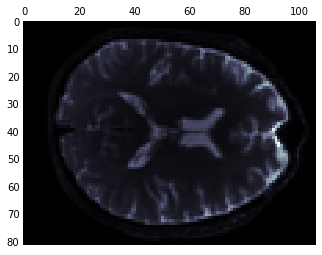

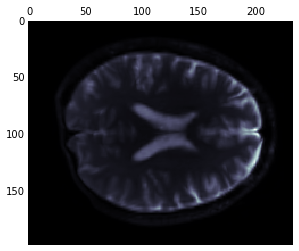

In [14]:
plt.matshow(mean_b0[:,:,mean_b0.shape[-1]//2], cmap=cm.bone)
plt.matshow(warped_b0[:,:,warped_b0.shape[-1]//2], cmap=cm.bone)

In [15]:
new_ni = nib.Nifti1Image(warped_b0, MNI_T2_affine)

In [16]:
new_ni.to_filename('./warped_b0.nii.gz')

In [17]:
LOCC_ni = nib.load('/Users/arokem/source/AFQ/templates/callosum2/L_Occipital.nii.gz')
ROCC_ni = nib.load('/Users/arokem/source/AFQ/templates/callosum2/R_Occipital.nii.gz')
midsag_ni = nib.load('/Users/arokem/source/AFQ/templates/callosum2/Callosum_midsag.nii.gz')

In [18]:
LOCC_data = LOCC_ni.get_data()
ROCC_data = ROCC_ni.get_data()
midsag_data = midsag_ni.get_data()

In [19]:
midsag_affine = midsag_ni.get_affine()

In [20]:
midsag_data = midsag_ni.get_data()

In [21]:
warped_midsag = mapping.transform_inverse(midsag_data)

In [22]:
#bin_warped_LOCC = np.ceil(warped_LOCC)
bin_warped_midsag = np.ceil(warped_midsag)

In [23]:
im = np.sum(np.ceil(bin_warped_midsag), axis=0)

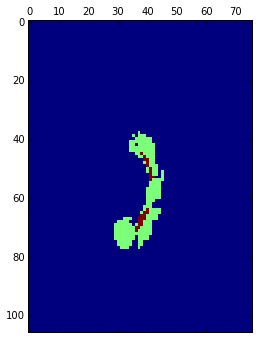

In [24]:
plt.matshow(im)

In [25]:
import scipy.ndimage as ndim

In [26]:
#filled_warped_LOCC= ndim.binary_dilation(bin_warped_LOCC, iterations=1).astype(int)
filled_warped_midsag= ndim.binary_fill_holes(bin_warped_midsag.astype(int)).astype(int)

In [27]:
np.unique(filled_warped_midsag)

array([0, 1])

In [28]:
filled_warped_midsag_ni = nib.Nifti1Image(filled_warped_midsag, hardi_affine)

In [29]:
filled_warped_midsag_ni.to_filename('./warped_midsag.nii.gz')

In [30]:
im = np.sum(np.ceil(ndim.binary_fill_holes(filled_warped_midsag)), axis=0)

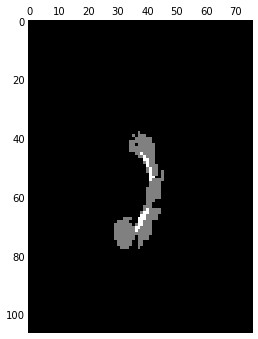

In [31]:
plt.matshow(im, cmap=cm.gray)

In [212]:
sl_from_file = nib.trackvis.read('./tensor_streamlines.trk', points_space='rasmm')

In [213]:
all_sl = [s[0] for s in sl_from_file[0]]

In [218]:
xform_sl = [s for s in dtu.move_streamlines(all_sl, np.linalg.inv(hardi_affine))]

In [219]:
neg = [np.any(s<0) for s in xform_sl]

In [220]:
np.any(neg)

False

In [221]:
sl_subset = xform_sl[:100]

In [223]:
sl_subset

[array([[ 50.25270081,  96.0565033 ,  37.4382019 ],
        [ 50.23454666,  96.30532837,  37.45428467],
        [ 50.22697449,  96.55490112,  37.46682358],
        [ 50.24972916,  96.8038559 ,  37.46795654],
        [ 50.3062973 ,  97.04720306,  37.45893097],
        [ 50.38703156,  97.28327179,  37.44301224],
        [ 50.48415375,  97.51220703,  37.4174118 ],
        [ 50.58127594,  97.7411499 ,  37.39181137]]),
 array([[ 66.56672668,  95.27169037,  45.71797943],
        [ 66.35770416,  95.18254089,  45.61375427],
        [ 66.17092133,  95.08058929,  45.48253632],
        [ 65.98498535,  94.97174072,  45.35573196],
        [ 65.78160095,  94.85731506,  45.26605988],
        [ 65.57368469,  94.73384857,  45.20259094],
        [ 65.36174011,  94.60314941,  45.18025208],
        [ 65.15462494,  94.46565247,  45.20662689],
        [ 64.96644592,  94.31820679,  45.27977753],
        [ 64.80579376,  94.16378784,  45.39311218],
        [ 64.69161987,  93.99419403,  45.5369873 ],
        [ 

In [234]:
reload(dts)

<module 'dipy.tracking.streamline' from '/Users/arokem/source/dipy/dipy/tracking/streamline.pyc'>

In [235]:
select_sl = dts.select_by_roi(xform_sl, [warped_midsag.astype(bool)], [True], 
                              affine=np.linalg.inv(filled_warped_midsag_ni.get_affine()))

In [236]:
t0 = time.time()
select_sl = [s for s in select_sl]
t1 = time.time()
print(t1 - t0)

83.7287199497


In [237]:
len(select_sl)

40820

In [238]:
select_sl

[array([[ 60.97130585,  79.78038025,  56.00232315],
        [ 61.05623245,  79.78713989,  55.76728821],
        [ 61.1606369 ,  79.78614807,  55.54013443],
        [ 61.26503754,  79.78515625,  55.31298065],
        [ 61.37718201,  79.79570007,  55.08979034],
        [ 61.51225281,  79.8128891 ,  54.88012695],
        [ 61.66059113,  79.83609009,  54.68022919],
        [ 61.78889084,  79.87382507,  54.4690094 ],
        [ 61.89756012,  79.92798615,  54.25047302],
        [ 61.99623108,  79.9899292 ,  54.02928162],
        [ 62.08672714,  80.05918884,  53.8067627 ],
        [ 62.17371368,  80.12164307,  53.58085632],
        [ 62.24361801,  80.17986298,  53.34799576],
        [ 62.30679321,  80.2387085 ,  53.11338043],
        [ 62.37524414,  80.30279541,  52.88162994],
        [ 62.44605255,  80.37277985,  52.6523056 ],
        [ 62.51130676,  80.44741058,  52.42280579],
        [ 62.57089996,  80.52883911,  52.19407272],
        [ 62.62398529,  80.62163544,  51.96808243],
        [ 62

In [241]:
from dipy.viz import fvtk
from dipy.viz.colormap import line_colors


In [ ]:
ren = fvtk.ren()
fvtk.add(ren, fvtk.streamtube(select_sl, line_colors(select_sl)))
fvtk.show(ren)